# Clustering Electricity Clients

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [1]:
import os
import 
os.getcwd()

'C:\\Users\\mciniello\\Desktop\\Python\\Updated projects'

In [2]:
pathToFile = 'C:\\Users\\mciniello\\Desktop\\Python\\Updated projects\\data\\'
fileName = 'LD2011_2014_raw.txt'

In [12]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [4]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [5]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [6]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [8]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [10]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the 2 days of 2012 for the first 2 clients

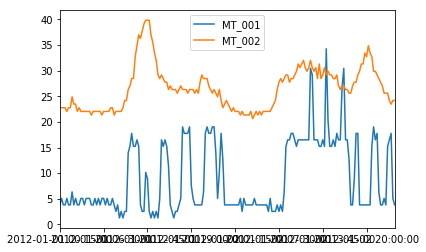

In [14]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [15]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [16]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [17]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [18]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [19]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [20]:
data.index.map(lambda x: x[11:])[0:20]

Index(['00:15:00', '00:30:00', '00:45:00', '01:00:00', '01:15:00', '01:30:00',
       '01:45:00', '02:00:00', '02:15:00', '02:30:00', '02:45:00', '03:00:00',
       '03:15:00', '03:30:00', '03:45:00', '04:00:00', '04:15:00', '04:30:00',
       '04:45:00', '05:00:00'],
      dtype='object')

In [21]:
data['hour'] = data.index.map(lambda x: x[11:]) #parse out time from index!

In [22]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [23]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [24]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

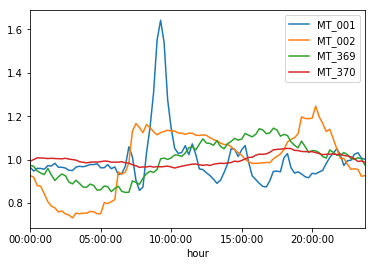

In [25]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [26]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it in the right format using a .product

## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

### 1.1 Building 'getInertia' Function
In case I need to revisit later!

In [27]:
#train test model
model = KMeans(n_clusters=5,random_state=0).fit(X)
# returns 5 unique cluster centers
model.cluster_centers_.shape

(5, 96)

In [28]:
# returns norm of vector (single observation, x1)
print("norm of x1: ", np.linalg.norm(X[0]))

# sum squared norm of (X1 - cluser center). Here is one observation:
print("squared norm of X1-cluster center: ", np.linalg.norm(X[0]-model.cluster_centers_[model.labels_[0]])**2)

# sum squared norm for each observation  to get inertia!
example_inertia = 0
for row in range(len(X)):
    example_inertia = example_inertia + np.linalg.norm(X[row]-model.cluster_centers_[model.labels_[row]])**2
print("example inertia: ",example_inertia)

# test example_inerta vs scikit learn cacs

print("SKlearn inertia: ", model.inertia_)

#wooohooo it works!    

norm of x1:  9.87442913819
squared norm of X1-cluster center:  1.59410052622
example inertia:  580.005064736
SKlearn inertia:  580.005064736


In [29]:
# Build the getInertia function
def getInertia(X,kmeans_model):
    '''This function should return the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans_model.cluster_centers_[kmeans_model.labels_[J]])**2
    return inertia

### 1.2 Building 'getInertia2' function
In case I need to revisit later!

In [30]:
#train test model
model = KMeans(n_clusters=5,random_state=0).fit(X)
# returns 5 unique cluster centers
model.cluster_centers_.shape

(5, 96)

In [31]:
# almost identical to inertia
# key different is that we sum the squarred norms of the second closest clusters:

# first step is to get a sorted list of all squarred norm values
squared_norms = [np.linalg.norm(X[0]-z) for z in model.cluster_centers_]
print("all squarred norms: ",squared_norms)

# sort!
sorted_norms = sorted(squared_norms)
print("sorted squared_norms: ", sorted_norms)

# choose the second highest value and add sum them for each observation!
sorted_norms[1]

all squarred norms:  [2.4911069191551731, 5.7126234246139331, 2.799443400257112, 6.6466217329503108, 1.2625769387322967]
sorted squared_norms:  [1.2625769387322967, 2.4911069191551731, 2.799443400257112, 5.7126234246139331, 6.6466217329503108]


2.4911069191551731

In [32]:
def getInertia2(X, kmeans_model):
    inertia2 = 0
    for J in range(len(X)):
        second_cluster = min(1,len(kmeans_model.cluster_centers_)-1) #this is just in case there is only 1 cluster
        distance_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans_model.cluster_centers_])[second_cluster]
        inertia2 = inertia2 + distance_to_center
    return inertia2

getInertia2(X,model)    

2440.1065119954314


### 1.3 Building custom ' silhouette' function

The silhouette $s(x)$ for a point $x$ is defined as:

$$ s(x) = \frac{b(x)-a(x)}{\max\{a(x),b(x)\}} $$

where 

- $a(x)$ is the average distance between $x$ and the points in the cluster $x$ belongs

- $b(x)$ is the lowest average distance between $x$ and the points the clusters $x$ does not belong to

$s(x)$ is a quantity in $[-1,1]$. The silhouette score is the average silhouette score among all the points: $\frac{1}{|X|} \sum_x s(x)$

In [33]:
def silhouette_singleRow(X,kmeans_model,row):
    # if there is only one point in the cluster, there will always be silhouette value of 0?
    points_in_cluster = X[kmeans_model.labels_==kmeans_model.labels_[row]]   
    if points_in_cluster.shape[0]==1:
        return 0
    else:
        # copmute a_x
        a_x_distances=[]
        for point in range(len(points_in_cluster)):
            a_x_distances.append((np.linalg.norm(X[row] - points_in_cluster[point])))
        a_x_distances = sorted([abs(x) for x in a_x_distances])[1:] #get rid of zero from 'distance to self'
        a_x=np.mean(a_x_distances)

        # compute b_x
        all_clusters = list(range(0,max(kmeans_model.labels_+1)))
        not_row_clusters = [x for x in all_clusters if x != kmeans_model.labels_[row]] #select other clusters
        avg_distances = []
        for cluster in not_row_clusters:
            X_cluster_specific = X[kmeans_model.labels_==cluster] # select rows of specific cluster
            avg_point_distances = []
            for point in range(len(X_cluster_specific)):
                avg_point_distances.append(np.linalg.norm(X[row] - X_cluster_specific[point]))
            avg_distances.append(np.mean(avg_point_distances))
        b_x=sorted([abs(x) for x in avg_distances])[0] #take first number as it represents distance from closest cluster

        # compute s_x
        s_x = (b_x-a_x)/(max(b_x,a_x))
        return s_x

def silhouette_allRow(X,kmeans_model):
    if model.labels_.sum() == 0:
        return "No samples... only one cluster you moron",0
    else:
        silhouette_samps = []
        for y in range(len(X)):
            silhouette_samps.append(silhouette_singleRow(X,kmeans_model,y))
        return silhouette_samps, np.mean(silhouette_samps)

In [34]:
#test to make sure custom function matches result of SKlearn function
model = KMeans(n_clusters=10, random_state=0).fit(X)
samps, s_x = silhouette_allRow(X,model)
print(s_x)
print(silhouette_score(X,model.labels_))

0.237530950573
0.237530950573


### 1.4 a) Determine optimal k

In [35]:
# set variables
max_k = 15
inertias_1 = []
inertias_2 = []
silhouettes = []

# run functions for each value of k
for k in range(1,max_k+1):
    model = KMeans(n_clusters=k,random_state=0).fit(X)
    inertias_1.append(getInertia(X,model))
    inertias_2.append(getInertia2(X,model))
    if k > 1:
        silhouettes.append(silhouette_allRow(X,model)[1])

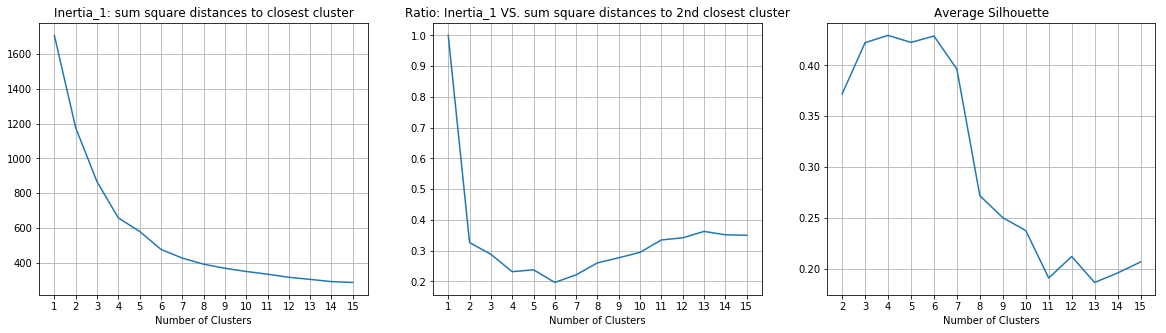

In [36]:
plt.figure(figsize=(20,5))

# plot inertia
plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_k+1),inertias_1)
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(1,max_k+1))
plt.grid()

# plot inertia1/inertia2
plt.subplot(1,3,2)
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_k+1),np.array(inertias_1)/np.array(inertias_2))
plt.xlabel("Number of Clusters")
plt.xticks(np.arange(1,max_k+1))
plt.grid()

# plot silhouette
plt.subplot(1,3,3)
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_k+1),silhouettes)
plt.xlabel("Number of Clusters")
plt.xticks(np.arange(2,max_k+1))
plt.grid()

plt.show()

### 1.5 b) Plot clusters
#### 6 clusters appears to be the optimal solution for this dataset
- The decline in inertia value seems to slow significantly at k=6
- Inertia1/Inertia2 starts to increase when k>6
- Silhouette is at its maximum at k=6

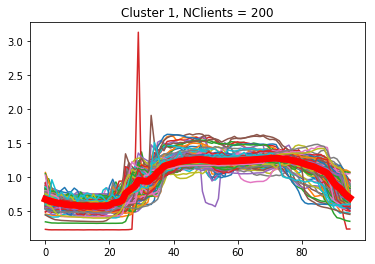

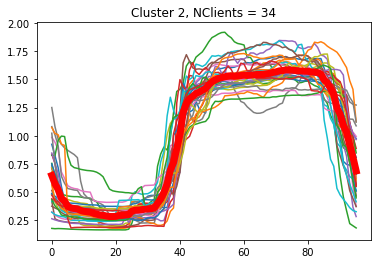

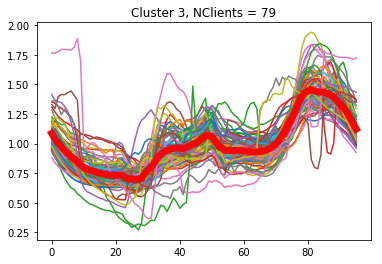

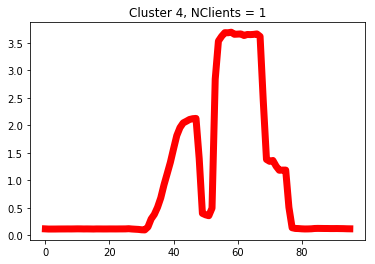

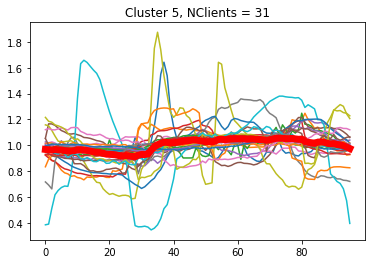

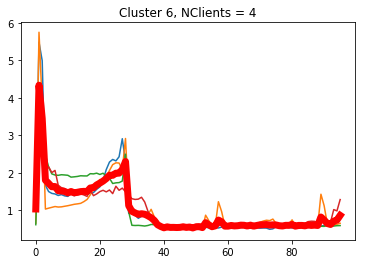

In [37]:
# lets plot the different clusters to see what they look like!

k=6 # the desired value
model = KMeans(n_clusters=k, random_state=0).fit(X)  # re-train

# Plots
for c in range(k):
    plt.plot(X[model.labels_==c].T)
    plt.plot(model.cluster_centers_[c],linewidth=7, color='red')
    plt.title('Cluster '+str(c+1)+', NClients = '+str(sum(model.labels_==c)))
    plt.show()

## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [43]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 
len(X)

730

In [44]:
X

[array([ 31.13325031,  28.64259029,  27.39726027,  24.90660025,
         24.28393524,  26.15193026,  26.15193026,  24.90660025,
         26.77459527,  23.66127024,  23.66127024,  21.17061021,
         23.03860523,  19.30261519,  18.67995019,  18.67995019,
         19.30261519,  19.30261519,  18.67995019,  19.30261519,
         18.05728518,  18.05728518,  17.43462017,  16.81195517,
         17.43462017,  17.43462017,  17.43462017,  17.43462017,
         18.67995019,  21.17061021,  19.30261519,  20.54794521,
         19.9252802 ,  21.17061021,  20.54794521,  21.79327522,
         24.90660025,  31.13325031,  23.66127024,  19.30261519,
         21.79327522,  20.54794521,  13.69863014,  16.81195517,
         15.56662516,  18.05728518,  18.05728518,  16.81195517,
         19.9252802 ,  16.81195517,  18.05728518,  20.54794521,
         16.81195517,  18.67995019,  21.17061021,  19.9252802 ,
         16.81195517,  16.18929016,  17.43462017,  18.05728518,
         18.67995019,  15.56662516,  18.

### 2.1 Explore data

In [41]:
# Check data shape
print("Days (rows): ", len(X))
print("Increments per day (columns): ", len(X[0]))

Days (rows):  730
Increments per day (columns):  96


In [47]:
## normalize data
X_normalized = [x/np.mean(x) for x in X]

print("Days (rows): ", len(X_normalized))
print("Increments per day (columns): ", len(X_normalized[0]))

Days (rows):  730
Increments per day (columns):  96


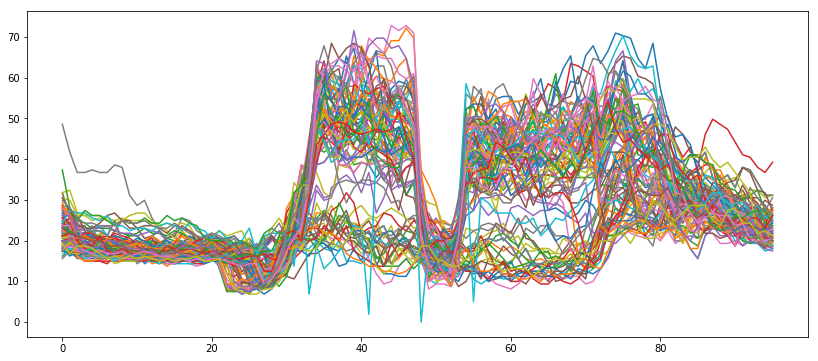

In [51]:
#explore original data

# select 50 random rows to show
import random as rand
n_obs=100
rand_obs = [rand.randint(0,729) for x in range(1,n_obs)]

for i in rand_obs:
    plt.plot(X[i])

plt.rcParams["figure.figsize"] = [14,6]
plt.show()

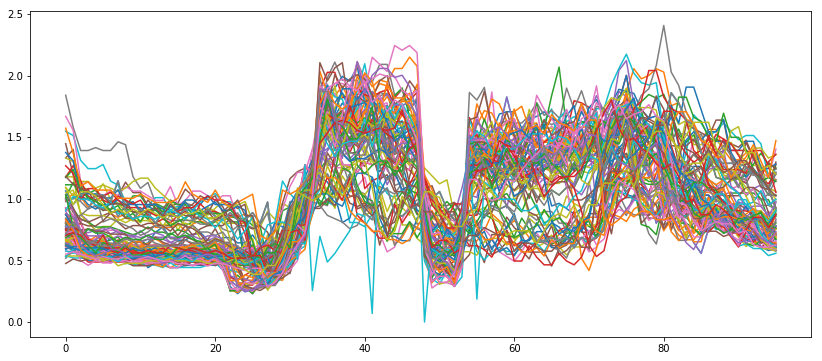

In [53]:
#explore normlaized data
for i in rand_obs:
    plt.plot(X_normalized[i])

plt.rcParams["figure.figsize"] = [14,6]
plt.show()

### 2.2 a) Determine optimal k vlaue
From the plot above, there appears to be a 2 distinct groups, however this pattern becomes less clear once the data is normalized. Lets see what the clusters give us!

In [54]:
# set variables
max_k = 15
inertias_1 = []
inertias_2 = []
silhouettes = []

# run functions for each value of k
for k in range(1,max_k+1):
    model = KMeans(n_clusters=k,random_state=0).fit(X_normalized)
    inertias_1.append(getInertia(X_normalized,model))
    inertias_2.append(getInertia2(X_normalized,model))
    # Use SKlearn silhouette_score as I did not build custom function to deal with arrays
    if k > 1:
        silhouettes.append(silhouette_score(X_normalized,model.labels_))

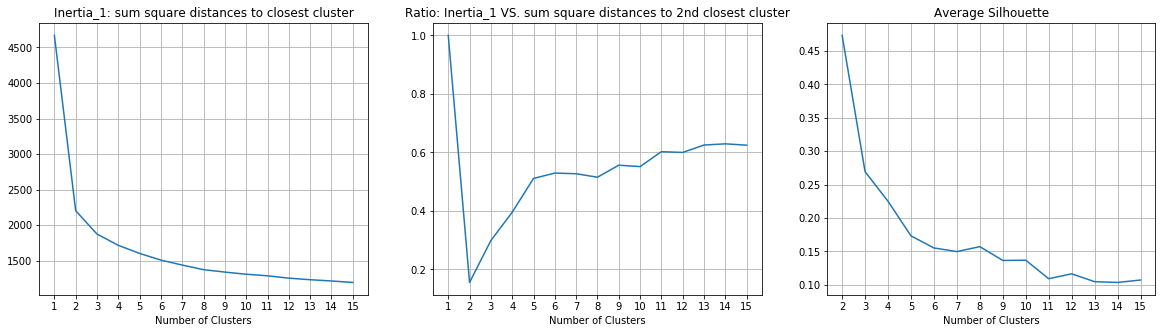

In [55]:
plt.figure(figsize=(20,5))

# plot inertia
plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_k+1),inertias_1)
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(1,max_k+1))
plt.grid()

# plot inertia1/inertia2
plt.subplot(1,3,2)
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_k+1),np.array(inertias_1)/np.array(inertias_2))
plt.xlabel("Number of Clusters")
plt.xticks(np.arange(1,max_k+1))
plt.grid()

# plot silhouette
plt.subplot(1,3,3)
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_k+1),silhouettes)
plt.xlabel("Number of Clusters")
plt.xticks(np.arange(2,max_k+1))
plt.grid()

plt.show()

##### As suspected from the earlier visualization, the optimal number of clusters for this dataset is 2

### 2.3 b) What do the clusters mean?

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [56]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])
print(len(daysyear))

weekdays = []
for i in range(delta.days + 1):
    weekdays.extend([D[(d1 + timedelta(days=i)).weekday()]])
print(len(weekdays))

730
730


#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [57]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

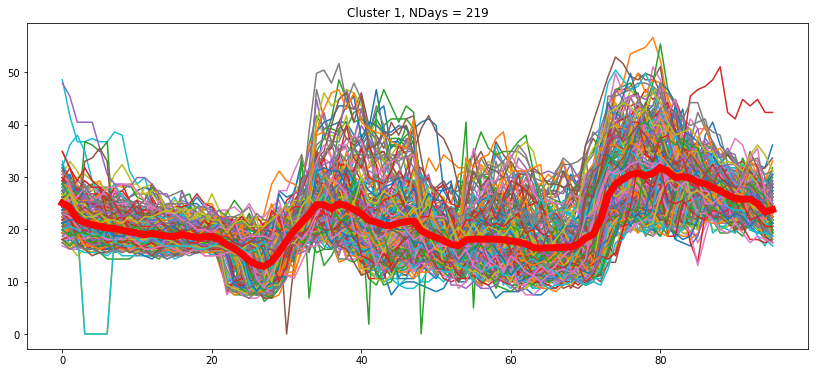

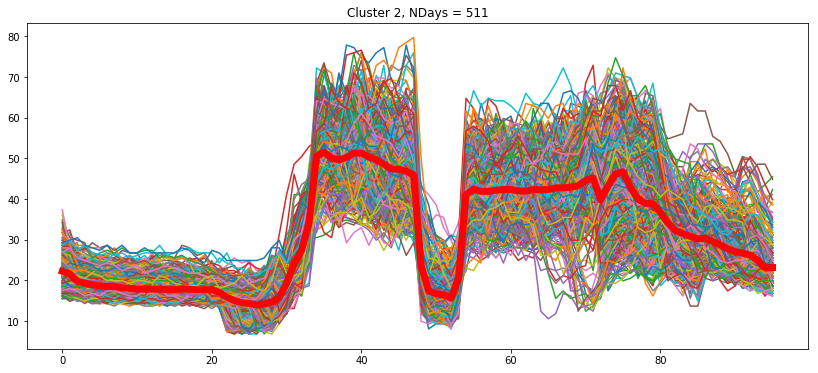

In [58]:
# lets plot the different clusters to see what they look like!

k=2 # the desired value
model = KMeans(n_clusters=k, random_state=0).fit(X)  # re-train

# reshape data
X_reshaped=np.reshape(X,(730,96))

# Plots
for c in range(k):
    plt.plot(X_reshaped[model.labels_==c].T)
    plt.plot(model.cluster_centers_[c],linewidth=7, color='red')
    plt.title('Cluster '+str(c+1)+', NDays = '+str(sum(model.labels_==c)))
    plt.show()

In [59]:
# Find the distribution of weekdays for each cluster
from collections import Counter
import datetime
import time
labels_1 = model.labels_==0
labels_2 = model.labels_==1

complete_date_1 = list(compress(daysyear,labels_1))
complete_date_2 = list(compress(daysyear,labels_2))

days_1 = list(compress(weekdays,labels_1))
days_2 = list(compress(weekdays,labels_2))

days_count_1 = Counter(days_1)
days_count_2 = Counter(days_2)

days_of_week = ['mon','tue', 'wed','thu', 'fri','sat', 'sun']

days_count_ordered_1 = []
days_count_ordered_2 = []
for day in days_of_week:
    days_count_ordered_1.append(days_count_1[day])
    days_count_ordered_2.append(days_count_2[day])
    
count_df = pd.DataFrame({"Cluster 1":days_count_ordered_1,
                        "Cluster 2":days_count_ordered_2},
                       index=days_of_week)
count_df['Cluster 1 Percent']=count_df['Cluster 1']/count_df['Cluster 1'].sum()
count_df['Cluster 2 Percent']=count_df['Cluster 2']/count_df['Cluster 2'].sum()
count_df


,Cluster 1,Cluster 2,Cluster 1 Percent,Cluster 2 Percent
mon,12,92,0.054795,0.180039
tue,12,93,0.054795,0.181996
wed,12,93,0.054795,0.181996
thu,10,94,0.045662,0.183953
fri,11,93,0.050228,0.181996
sat,58,46,0.264840,0.090020
sun,104,0,0.474886,0.000000


In [60]:
# Find the distribution of months for each cluster

months=[daysyear[i][-5:-3] for i in range(0,len(daysyear))]

months_1 = list(compress(months,labels_1))
months_2 = list(compress(months,labels_2))

months_count_1 = Counter(months_1)
months_count_2 = Counter(months_2)

months_of_year = ['01','02','03','04','05','06','07','08','09','10','11','12']
months_count_ordered_1 = []
months_count_ordered_2 = []
for month in months_of_year:
    months_count_ordered_1.append(months_count_1[month])
    months_count_ordered_2.append(months_count_2[month])
    
count_df = pd.DataFrame({"Cluster 1":months_count_ordered_1,
                        "Cluster 2":months_count_ordered_2},
                       index=months_of_year)

count_df['Cluster 1 Percent']=count_df['Cluster 1']/count_df['Cluster 1'].sum()
count_df['Cluster 2 Percent']=count_df['Cluster 2']/count_df['Cluster 2'].sum()
count_df


,Cluster 1,Cluster 2,Cluster 1 Percent,Cluster 2 Percent
01,15,47,0.068493,0.091977
02,14,42,0.063927,0.082192
03,22,40,0.100457,0.078278
04,19,41,0.086758,0.080235
05,21,41,0.095890,0.080235
06,18,42,0.082192,0.082192
07,12,50,0.054795,0.097847
08,47,15,0.214612,0.029354
09,13,47,0.059361,0.091977
10,10,52,0.045662,0.101761


# Conclusion

The distribution of the months seems to be similar for each cluster. However it is fairly clear that cluster one is composed primarily of weekend days (sat and sun), where as cluster 2 is composed of weekdays (Mon-Fri). 